In this notebook I will take the cleaned data and do some basic EDA to establish some clear electoral trends. While the notebook itself with focus more on tool and methodology, the long form article will provide more editorilzed analysis. As per usual first we will import out data and our libraries. 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('pres_election.csv')
df_pop = pd.read_csv('pres_pop_vote.csv')
df = df.loc[df['state'] != 'DISTRICT OF COLUMBIA']


Naturally, the first graph we may want to look at is how the parties have preformed in election in the nation at large. While the popular vote does not determine who wins the white house it is still interested to see. The graph belows follows popular vote % from 1976 (the election prior to Reagan) to 2020. The slump in the 1992 and 1996 elections can be attributed to a strong 3rd party showing from Ross Perot. I have included another graph tracking just the total 3rd party (in yellow) which shows how unique the Perot effect was in the mid-90s. 

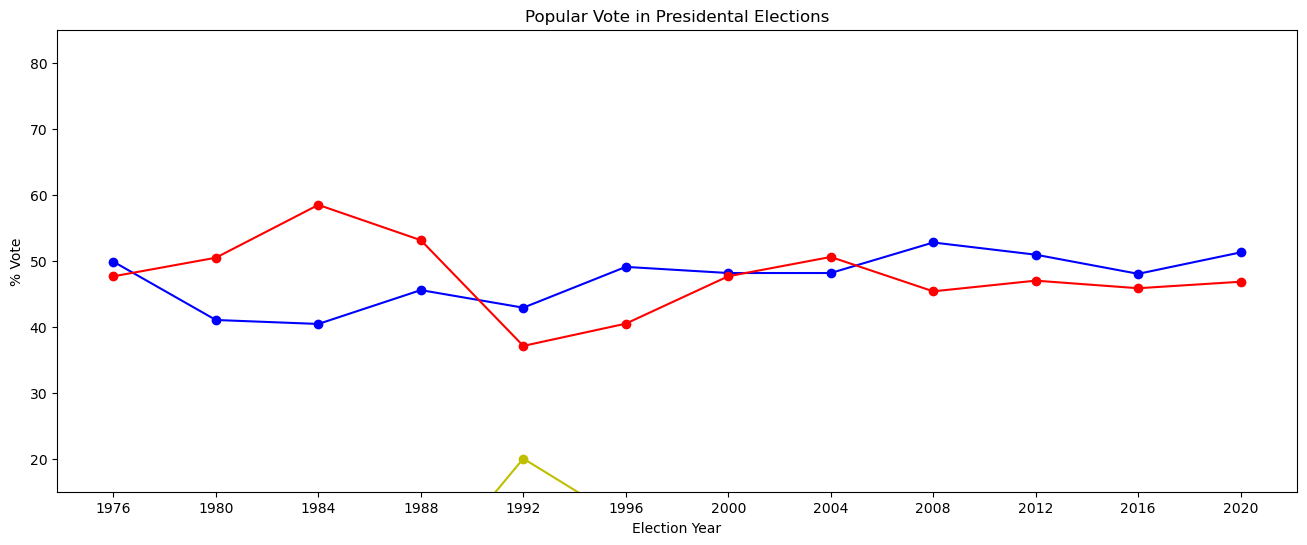

In [5]:
plt.figure(figsize = (16,6))
plt.xticks(np.arange(1976, 2024, step=4))
plt.ylim(15,85)
plt.plot(df_pop['year'],(df_pop['DEMOCRAT_%']*100),'-bo')
plt.plot(df_pop['year'],(df_pop['REPUBLICAN_%']*100),'-ro')
plt.plot(df_pop['year'],(df_pop['OTHER_%']*100),'-yo')


plt.title('Popular Vote in Presidental Elections')
plt.xlabel('Election Year')
plt.ylabel('% Vote')

plt.show()

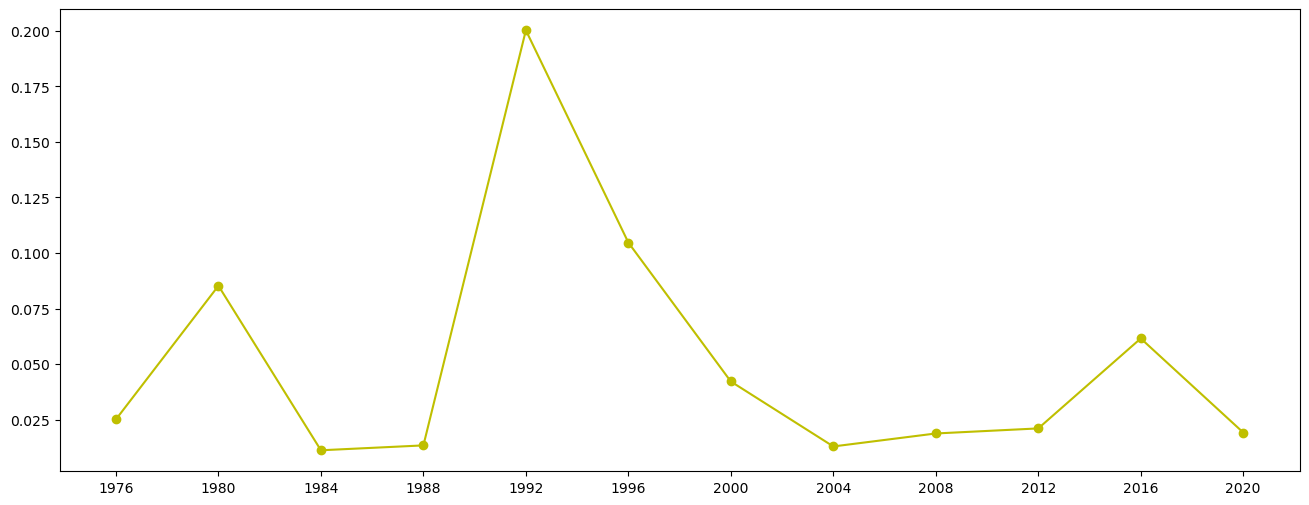

In [6]:
plt.figure(figsize = (16,6))
plt.xticks(np.arange(1976, 2024, step=4))
plt.plot(df_pop['year'],df_pop['OTHER_%'],'-yo')
plt.show()

Next we can take a look at state-level voting trends. The violin plot below show the distribution of votes (for both parties) in Presidental elections since 1976. The asymmetric violins seen in the 1980's underscores the importance of Reagan as a political force. We can also see that since 1992, there has a persistent increase in polarization in American politics. This can also be confirmed by looking at the standard deviation of the percentage of vote the parties received by state for each election in the next graph. This increasing standard deviation once again points to states voting in a more skewed manner. 

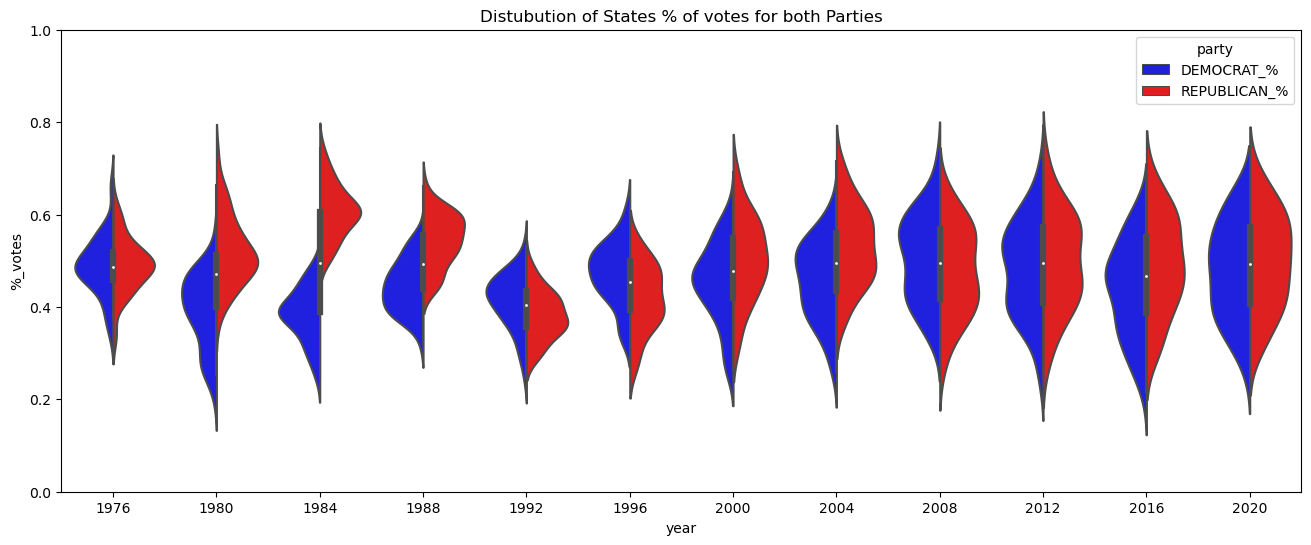

In [7]:
df_temp = df[['year','state','DEMOCRAT_%','REPUBLICAN_%']].melt(id_vars = ['year','state'], var_name = 'party',
                                                               value_name = '%_votes')

plt.figure(figsize = (16,6))
sns.violinplot(x = 'year', y = '%_votes',hue = 'party', data = df_temp, 
               split = 'True', palette = {'DEMOCRAT_%': 'b', 'REPUBLICAN_%': 'r'})
plt.ylim(0,1)
plt.title('Distubution of States % of votes for both Parties')
plt.show()

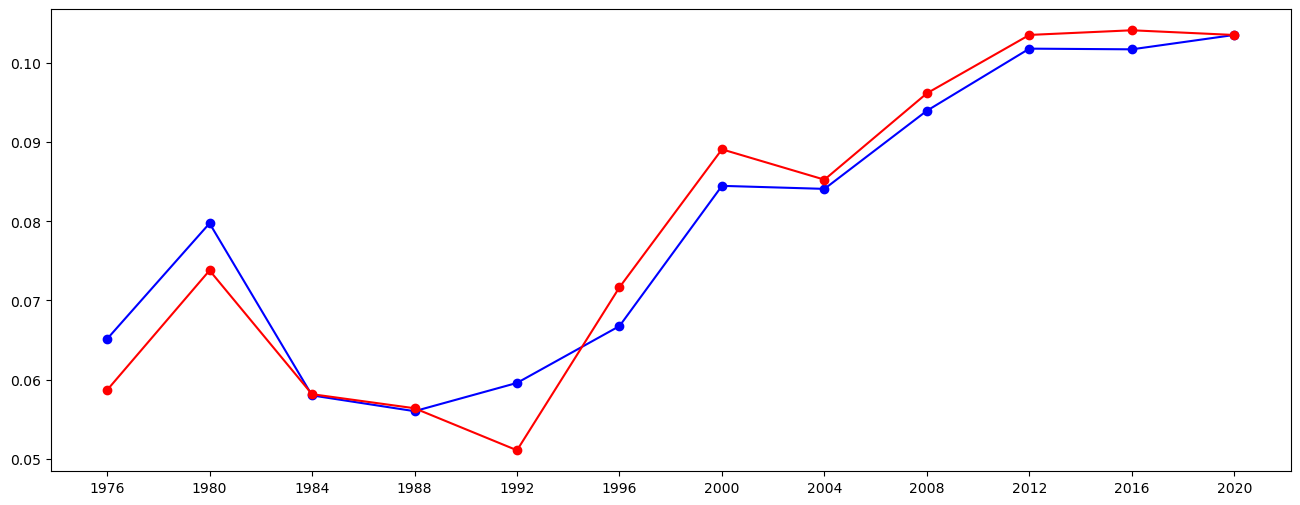

In [8]:
df_temp = df[['year','DEMOCRAT_%','REPUBLICAN_%']].groupby(['year']).std().reset_index()


plt.figure(figsize = (16,6))
plt.xticks(np.arange(1976, 2024, step=4))
plt.plot(df_temp['year'],df_temp['DEMOCRAT_%'],'-bo')
plt.plot(df_temp['year'],df_temp['REPUBLICAN_%'],'-ro')
plt.show()

One attempt to "normalize" our election scores is to compare how well (or poorly) the party did in each state compared to how they preformed nationally. Here I did that by grouping the states by the election year, and taking finding the mean preformance for both parties that year. In the next cell I create the 'net_diff' metric to consilidate this data into a single stat. 

In [10]:
df_diff = df[['year','state','DEMOCRAT_%','REPUBLICAN_%']]

df_diff[['DEMOCRAT_%','REPUBLICAN_%']] = df_diff[['DEMOCRAT_%','REPUBLICAN_%']].sub(
            df_diff[['year','DEMOCRAT_%','REPUBLICAN_%']].groupby(['year']).transform('mean'))

df_diff[['DEMOCRAT_%','REPUBLICAN_%']] = df_diff[['DEMOCRAT_%','REPUBLICAN_%']] * 100

df_diff.head()

C:\Users\rites\AppData\Local\Temp\ipykernel_25752\244298854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff[['DEMOCRAT_%','REPUBLICAN_%']] = df_diff[['DEMOCRAT_%','REPUBLICAN_%']].sub(
C:\Users\rites\AppData\Local\Temp\ipykernel_25752\244298854.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff[['DEMOCRAT_%','REPUBLICAN_%']] = df_diff[['DEMOCRAT_%','REPUBLICAN_%']] * 100


,year,state,DEMOCRAT_%,REPUBLICAN_%
0,1976,ALABAMA,6.872154,-6.349215
1,1976,ALASKA,-13.201984,8.940489
2,1976,ARIZONA,-9.055137,7.402050
3,1976,ARKANSAS,16.106613,-14.059749
4,1976,CALIFORNIA,-0.900293,0.784228


To make sure that this new stat (net_diff) does not skew very hard one way or the other I checked the distribution using a histogram. I also looked at the mean of the net_diff, and found that it basically stays at zero for all election years (note the 1e-14 adjustment on the x-axis). 

C:\Users\rites\AppData\Local\Temp\ipykernel_25752\3086003129.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['Net_Diff'] = df_diff['DEMOCRAT_%'] - df_diff['REPUBLICAN_%']


<AxesSubplot:>

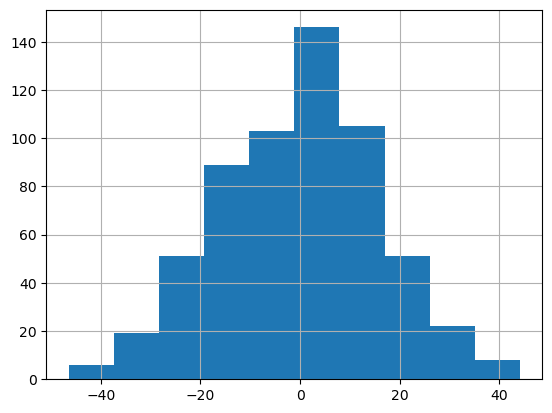

In [12]:
df_diff['Net_Diff'] = df_diff['DEMOCRAT_%'] - df_diff['REPUBLICAN_%']

df_diff['Net_Diff'].hist()

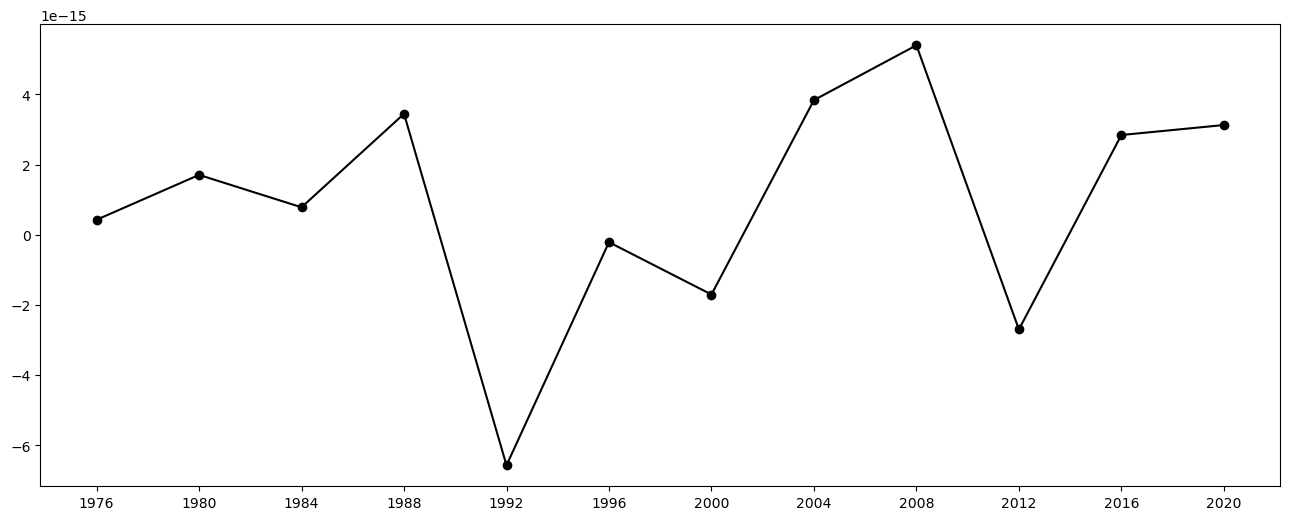

In [17]:
df_temp = df_diff[['year','Net_Diff']].groupby(['year']).mean().reset_index()


plt.figure(figsize = (16,6))
plt.xticks(np.arange(1976, 2024, step=4))
plt.plot(df_temp['year'],df_temp['Net_Diff'],'-ko')
plt.show()

Next, I decided to assign the states label for the election indicating how "competitive" they were. The advantage of this metric is in uncompettitve elections (such as 1984) we may still be interested to see which states were far more 'blue' then the national average. This can help us identify trends. Here I decided to use the common political nomenclature or 'swing','lean', and 'safe'. 

In [19]:
conditions = [
    df_diff['Net_Diff'].between(-6,6),
    df_diff['Net_Diff'].abs()<14,
    df_diff['Net_Diff'].abs()>14
]

values = ['Swing', 'Lean', 'Safe']

df_diff['Status'] = np.select(conditions, values)

df_diff.head()

C:\Users\rites\AppData\Local\Temp\ipykernel_25752\4207284309.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['Status'] = np.select(conditions, values)


,year,state,DEMOCRAT_%,REPUBLICAN_%,Net_Diff,Status
0,1976,ALABAMA,6.872154,-6.349215,13.221369,Lean
1,1976,ALASKA,-13.201984,8.940489,-22.142474,Safe
2,1976,ARIZONA,-9.055137,7.402050,-16.457187,Safe
3,1976,ARKANSAS,16.106613,-14.059749,30.166362,Safe
4,1976,CALIFORNIA,-0.900293,0.784228,-1.684521,Swing


In [20]:
df_diff[df_diff['Status']=='Swing']

,year,state,DEMOCRAT_%,REPUBLICAN_%,Net_Diff,Status
4,1976,CALIFORNIA,-0.900293,0.784228,-1.684521,Swing
6,1976,CONNECTICUT,-2.121414,2.917358,-5.038773,Swing
7,1976,DELAWARE,3.113973,-2.376466,5.490439,Swing
9,1976,FLORIDA,3.070991,-2.321652,5.392643,Swing
11,1976,HAWAII,1.736884,-0.902802,2.639686,Swing
...,...,...,...,...,...,...
594,2020,NORTH CAROLINA,0.892093,-0.098147,0.990240,Swing
596,2020,OHIO,-2.454780,3.238821,-5.693601,Swing
599,2020,PENNSYLVANIA,2.314377,-1.188867,3.503244,Swing
604,2020,TEXAS,-1.215109,2.025125,-3.240233,Swing


Here is an example of the net_diff statistic in action. In 1984, Reagan won the state with 56.17% of the vote, even though the net_diff for that year was positive (therfore indicating DNC support). However, the state as a whole was more blue then the country. We can see that by looking at net_diff we can establish a clear trend, and now Illinios is an extremely safe blue state. 

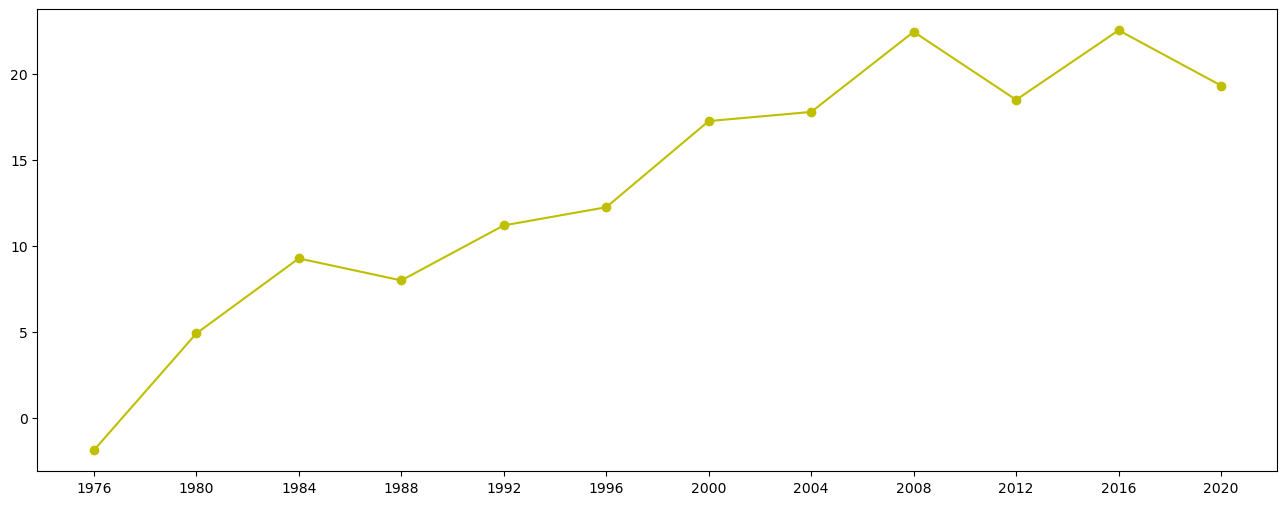

,year,Net_Diff
13,1976,-1.860282
64,1980,4.925058
115,1984,9.285432
166,1988,8.008205
217,1992,11.203730
268,1996,12.259642
319,2000,17.265318
370,2004,17.796465
421,2008,22.450503
472,2012,18.498815


In [21]:
df_temp = df_diff.loc[df_diff['state'] == 'ILLINOIS',['year','Net_Diff']]

plt.figure(figsize = (16,6))
plt.xticks(np.arange(1976, 2024, step=4))
plt.plot(df_temp['year'],df_temp['Net_Diff'],'-yo')
plt.show()

df_temp

In [165]:
df_diff.to_csv('diff_data.csv', index = False)

Finally, after deriving our metric we can continue to the data visualization portion. While the excel visuals are not seperatly included, the next notebook contains the visuals dervied from python and the process behind creating them. For deeper political analysis as well as implications of the data please refer to the main article. 